<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Learning%20CNN%20and%20MLOps%20with%20Malaria%20Diagnosis/Skeleton_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
!pip install wandb

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import datetime
import io
import wandb
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, RandomCrop, RandomZoom, Resizing
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, F1Score, AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import L1, L2
from tensorflow.image import flip_left_right, flip_up_down, rot90, resize, transpose, central_crop, random_crop, random_brightness, adjust_brightness, adjust_contrast
from tensorboard.plugins.hparams import api as hp
import albumentations as A
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from google.colab import drive

In [ ]:
!wandb login

In [ ]:
wandb.init(project = 'malaria_detection', entity = 'jagaadhep')
#EVERYTHING WE DO AFTER THIS IS STORED IN THE RUN (LIKE IN LOGS)

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 3,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}

configuration = wandb.config

im_size = configuration['IM_SIZE']
dropout_rate = configuration['DROPOUT_RATE']
regularization_rate = configuration['REGULARIZATION_RATE']
n_filters = configuration['N_FILTERS']
kernel_size = configuration['KERNEL_SIZE']
pool_size = configuration['POOL_SIZE']
n_strides = configuration['N_STRIDES']
learning_rate = configuration['LEARNING_RATE']

#USE THESE VARIABLES FOR THEIR APPROPRIATE PLACES IN THE MODEL/PROJECT/CODE
#USE WandbCallback() IN CALLBACKS IN MODEL.FIT()
#AFTER FITTING AND TRAINING MODEL, YOU COULD GO TO YOUR WANDB WEBSITE DASHBOARD AND SEE EXACTLYWHAT WENT ON DURING TRAINING PROCESS LIKE METRICS, SYSTEM USAGE, MODEL ARCHITECTURE, LOGS, MODEL, WANDB - METADATA, RUN OVERVIEW
#IF YOU HAVE ANY DOUBT, GO TO WANDB DOCUMENTATION AND CLICK ON KERAS/TENSORFLOW


In [ ]:
data, data_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

### **DATA SPLITTING**

In [ ]:
dataset_ = tf.data.Dataset.range(10)
print(list(dataset_.as_numpy_iterator()))
dats = dataset_.take(6)
print(list(dats.as_numpy_iterator()))
datsa = dataset_.skip(3)
print(list(datsa.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[3, 4, 5, 6, 7, 8, 9]


In [ ]:
def splitting(dataset, train_ratio, val_ratio, test_ratio):
  data_size = len(dataset)
  train_data = dataset.take(int(train_ratio * data_size))
  val_test_data = dataset.skip(int(train_ratio * data_size))
  val_data  = val_test_data.take(int(val_ratio * data_size))
  test_data = val_test_data.skip(int(val_ratio * data_size))
  return train_data, val_data, test_data

In [ ]:
train_ratio = eval(input("Train ratio : "))
val_ratio = eval(input("Validation ratio : "))
test_ratio = eval(input("Test ratio : "))


Train ratio : 0.8
Validation ratio : 0.1
Test ratio : 0.1


In [ ]:
train_data, val_data, test_data = splitting(data, train_ratio, val_ratio, test_ratio)

AttributeError: 'list' object has no attribute 'take'

 we see above data is a list so, we use data[0] to call train data

In [ ]:
train_data, val_data, test_data = splitting(data[0], train_ratio, val_ratio, test_ratio)

### **DATA VISUALIZATION**

In [ ]:
data_info.features['label'].int2str(0)

'parasitized'

In [ ]:
data_info.features['label'].int2str(1)

'uninfected'

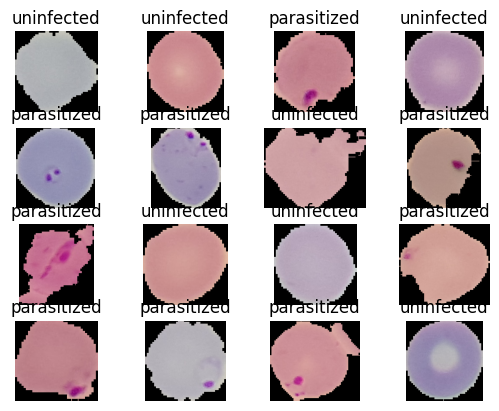

In [ ]:
for i, (image, label) in enumerate(train_data.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(data_info.features['label'].int2str(label))
  plt.axis("off")

### **DATA PROCESSING**

In [ ]:
im_size = int(input("image size : "))

image size : 224


In [ ]:
for image, label in train_data.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
#resizing and rescaling using tf.image
@tf.function #converting function in eager mode to graph (graph mode)
def resize_rescale(image, label):
  return tf.image.resize(image, (im_size, im_size))/255.0, label

Here we see that the image has been resized to 224 x 224 and then rescaled or normalized by dividing by 255

### **DATA AUGMENTATION**

**USING TF.IMAGE**

In [ ]:
#augmentation using tf.image
@tf.function #converting function in eager mode to graph (graph mode)
def augment(image, label):
  tf.config.run_functions_eagerly(True) #run functions in eager mode
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image, k = tf.random.uniform(shape =[], minval = 0, maxval = 2, dtype = tf.int32, seed = 42)) #randomize k to introduce randomness
  image = tf.image.stateless_random_flip_left_right(image, seed = 42)
  return image, label
train_data = train_data.shuffle(8, reshuffle_each_iteration = True).map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.shuffle(8, reshuffle_each_iteration = True).map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.shuffle(8, reshuffle_each_iteration = True).map(resize_rescale)

**USING TF.KERAS.LAYERS**

In [ ]:
#resizing and rescaling using tf.keras.layers
resize_rescale_layer = Sequential([
    Resizing(im_size, im_size),
    Rescaling(1.0/255)
])

In [ ]:
#Custom augmentation layer
class RotNinety(Layer):
  def __init__(self):
    super().__init__()
  @tf.function #converting function in eager mode to graph (graph mode)
  def call(self, image):
    return tf.image.rot90(image, k = tf.random.uniform(shape =[], minval = 0, maxval = 2, dtype = tf.int32, seed = 42))

In [ ]:
#augmentation using tf.keras.layers
augment_ = Sequential([
    RandomRotation(factor = (0.25, 0.2501)), #or use RotNinety()     #so that all images all rotated by about 90 degrees
    RandomFlip(mode = 'horizontal')
])
@tf.function #converting function in eager mode to graph (graph mode)
def augment_layer(image, labels):
  return augment_(resize_rescale_layer(image), training = True), labels
train_data = train_data.shuffle(8, reshuffle_each_iteration = True).batch(1).prefetch(tf.data.AUTOTUNE) #since we are batching and then doing resizing in training, batch size other than 1 would result in the inputs having different shapes
val_data = val_data.shuffle(8, reshuffle_each_iteration = True).batch(1).prefetch(tf.data.AUTOTUNE) #lesser the batch size, more the training time
test_data = test_data.shuffle(8, reshuffle_each_iteration = True)

**MIXUP AUGMENTATION**

MIXUP AUGMENTATION MAY BE NECESSARILY BE SUITED TO EVERY PROBLEM STATEMENT LIKE HERE

In [ ]:
#GETTING LAMBDA FROM BETA DISTRIBUTION
lamda = tfp.distributions.Beta(0.2, 0.2)
print(lamda.sample())
print(lamda.sample(1))
print(lamda.sample(4))
print(lamda.sample((4,3)))
print(lamda.sample(1).numpy())

tf.Tensor(0.9451205, shape=(), dtype=float32)
tf.Tensor([7.1846165e-09], shape=(1,), dtype=float32)
tf.Tensor([0.11152684 0.4213449  0.94487906 0.9883088 ], shape=(4,), dtype=float32)
tf.Tensor(
[[0.04197026 0.9870051  0.00843861]
 [0.00129065 0.86064535 0.5655213 ]
 [0.99987745 0.22131848 0.85540223]
 [0.957042   0.25870073 0.99399865]], shape=(4, 3), dtype=float32)
[0.99994075]


In [ ]:
#CREATING DATASETS FOR MIXUP
train_dataset_1 = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
#AFTER FINDING LAMDA, WE JUST APPLY THE FORMULA FOR MIXUP
#X' = LAMDA * X1 + (1=LAMDA) * X2 WHERE X1 AND X2 ARE INPUT IMAGES
#LABEL Y' = LAMDA * Y1 + (1=LAMDA) * Y2

def mixup(train_dataset_1, train_dataset_2):
  (image1, label1), (image2, label2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.4,0.4)
  lamda = lamda.sample(1)[0]

  image = lamda * image1 + (1 - lamda) * image2
  label = lamda * tf.cast(label1, dtype = tf.float32) + (1 - lamda) * tf.cast(label2, dtype = tf.float32)

  return image, label

In [ ]:
train_data = mixed_dataset.shuffle(8, reshuffle_each_iteration = True).map(mixup).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.shuffle(8, reshuffle_each_iteration = True).map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.shuffle(8, reshuffle_each_iteration = True).map(resize_rescale)

In [ ]:
#plt.imshow(image/255)

**CUTMIX AUGMENTATION**

CUTMIX AUGMENTATION MAY BE NECESSARILY BE SUITED TO EVERY PROBLEM STATEMENT LIKE HERE BECAUSE IF WE CROP OUT THE PATCHTHAT DEFINES A CELL AS PARASITIC, THEN THE MODEL CAN GET CONFUSED AS IT WILL LOOK LIKE A HEALTHY CELL BUT WILL HAVE A LABEL BETWEEN HEALTHY AND PARASITIC

In [ ]:
#CREATING DATASETS FOR CUTMIX
train_dataset_1 = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def box(lamda):
  r_x = tf.cast(tfp.distribution.Uniform(0,im_size).sample(1)[0], dtype = tf.int32) #im_size = width #r_x = center x coordinate
  r_y = tf.cast(tfp.distribution.Uniform(0,im_size).sample(1)[0], dtype = tf.int32) #im_size = height  #r_y = center y coordinate

  r_w = tf.cast(im_size * tf.math.sqrt(1 - lamda), dtype = tf.int32)  #im_size = width  #r_w = width of image
  r_h = tf.cast(im_size * tf.math.sqrt(1 - lamda), dtype = tf.int32)  #im_size = height #r_h = height of image

  r_x = tf.clip_by_value(r_x - (r_w//2), 0, im_size) #r_x = top left corner's x coordinate clipped to not extend beyond the image
  r_y = tf.clip_by_value(r_y - (r_h//2), 0, im_size) #r_y = top left corner's y coordinate clipped to not extend beyond the image

  x_b_r = tf.clip_by_value(r_x + (r_w//2), 0, im_size) #x_b_r = bottom right corner's x coordinate clipped to not extend beyond the image
  y_b_r = tf.clip_by_value(r_x + (r_w//2), 0, im_size) #y_b_r = bottom right corner's y coordinate clipped to not extend beyond the image

  r_w = x_b_r - r_x
  if r_w == 0:
    r_w = 1
  r_h = y_b_r - r_y
  if r_h == 0:
    r_h = 1
  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image1, label1), (image2, label2) = train_dataset_1, train_dataset_2
  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image2, r_y, r_x, r_h, r_w)
  pad_2 = tf.pad_to_bounding_box(crop_2, r_y, r_x, im_size, im_size)

  crop_1 = tf.image.crop_to_bounding_box(image1, r_y, r_x, r_h, r_w)
  pad_1 = tf.pad_to_bounding_box(crop_1, r_y, r_x, im_size, im_size)

  image = image1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w * r_h)/(im_size * im_size), dtype = tf.float32)
  label = lamda * tf.cast(label1, dtype = tf.float32) + (1 - lamda) * tf.cast(label2, dtype = tf.float32)

  return image, label

In [ ]:
train_data = mixed_dataset.shuffle(8, reshuffle_each_iteration = True).map(cutmix).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.shuffle(8, reshuffle_each_iteration = True).map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.shuffle(8, reshuffle_each_iteration = True).map(resize_rescale)

In [ ]:
#TO VISUALIZE CUTMIP AUGMENTED IMAGE
original_image, label = next(iter(train_data))
plt.imshow(original_image[0])

**DATA AUGMENTATION WITH ALBUMENTATIONS**

In [ ]:
transforms = A.Compose([
    A.Resize(im_size, im_size),
    A.OneOf([A.HorizontalFlip(),
             A.VerticalFlip()], p = 0.3),
    A.RandomRotate90(),
    A.RandomGridShuffle(grid = (3,3)),
    A.RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2),
    A.Cutout(),
    A.Sharpen()
])

In [ ]:
def aug_albument(image):
  data = {'image':image}
  image = transforms(**data) #The ** syntax is used in Python to unpack the values from a dictionary and pass them as keyword arguments to a function.
  image = image['image']
  image = tf.cast(image/255., dtype = tf.float32)
  return image

In [ ]:
def process_data(image, label):
  aug_img = tf.numpy_function(func = aug_albument, inp = [image], Tout = tf.float32)
  return aug_img, label

In [ ]:
train_data = train_data.shuffle(buffer_size = 1024, reshuffle_each_iteration = True).map(process_data).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#visualizing augmented image
im, _ = next(iter(train_data))
plt.imshow(im[0])

In [ ]:
plt.figure(fgisize = (10,10))
for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

### **WANDB DATASET VERSIONING**

**STEP 1) LOADING AND STORING ORIGINAL DATASET IN WANDB**

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

In [ ]:
#CREATE A NEW FOLDER NAMED 'DATASET'
#STORE EACH DATAPOINT AS A SEPARATE FILE IN THE DATASET FOLDER
k = 0
for data in dataset[0]:
  with open("dataset/malaria_dataset_" + str(k) + ".npz", mode = "wb") as file:
    np.savez(file, data)
  k += 1

In [ ]:
#STORE ALL FILES IN DATASET FOLDER TO WANDB
def load_original_data():
  with wandb.init(project = 'malaria__detection', entity = 'jagaadhep') as run:
    original_data = wandb.Artifact(name = "raw_dataset",
                                  type = "raw_data",
                                  description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cell data",
                                  metadata = {"source" : "TFDS",
                                              "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                                              "source_code": "tfds.image_classification.Malaria",
                                              "version": "1.0.0",
                                              "download_size": "337.08 MiB"})
    original_data.add_dir("dataset/")
    run.log_artifact(original_data)

In [ ]:
load_original_data()

**STEP 2) CREATING A PREPROCESSED DATASET**

In [ ]:
#STORE ALL FILES IN DATASET FOLDER TO WANDB
def preprocess_data():
  with wandb.init(project = 'malaria__detection', entity = 'jagaadhep') as run:
    #DOWNLOAD AND GET THE ARTIFACT DATA FROM WANDB FOR USAGE
    artifact = run.use_artifact("jagaadhep/malaria__detection/new_dataset:v1", type = "raw_data")
    artifact_dir = artifact.download()
    print(artifact_dir)

    preprocessed_data = wandb.Artifact(name = "preprocessed_dataset",
                                  type = "preprocessed_data",
                                  description = "A preprocessed version of the Malaria dataset")

    artifact_directory = artifact_dir + "/"

    dataset_x = []
    dataset_y = []
    for file_ in os.listdir(artifact_directory): #USE 'for file_ in os.listdir(artifact_directory)[:1000]:' BECAUSE WE DON'T HAVE ENOUGH MEMORY TO STORE ABOUT 22000 IN A SINGLE FILE
      with open(artifact_directory + file_, "rb") as file:
        npz_array = np.load(file, allow_pickle = True)
        x, y = npz_array.f.arr_0
        dataset_x.append(resize_rescale(x)) #DATA PREPROCESSING : RESIZE AND RESCALE
        dataset_y.append(y)
    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))
    with preprocessed_data.new_file("preprocessed_dataset") as file:
      np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

**STEP 3) SPLIT THE PREPROCESSED DATASET INTO TRAIN DATASET, VALIDATION DATASET AND TEST DATASET**

In [ ]:
def split_data():
  with wandb.init(project = 'malaria__detection', entity = 'jagaadhep') as run:
    #DOWNLOAD AND GET THE ARTIFACT DATA FROM WANDB FOR USAGE
    artifact = run.use_artifact("jagaadhep/malaria__detection/preprocessed_dataset:v2", type = "preprocessed_data")
    artifact_dir = artifact.download()
    print(artifact_dir)

    train_data = wandb.Artifact(name = "train_dataset",
                                  type = "preprocessed_data",
                                  description = "Training Dataset")

    val_data = wandb.Artifact(name = "val_dataset",
                                  type = "preprocessed_data",
                                  description = "Validation Dataset")

    test_data = wandb.Artifact(name = "test_dataset",
                                  type = "preprocessed_data",
                                  description = "Test Dataset")

    artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

    with open(artifact_file, "rb") as file:
      npz_array = np.load(file, allow_pickle = True)
      arr = npz_array.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1
    data_len = len(arr[0])

    train_arr = [arr[0][0: int(train_split * data_len)], arr[1][0: int(train_split * data_len)]]
    val_arr = [arr[0][int(train_split * data_len) : int((train_split + val_split) * data_len)], arr[1][int(train_split * data_len) : int((train_split + val_split) * data_len)]]
    test_arr = [arr[0][int((train_split + val_split) * data_len) : ], arr[1][int((train_split + val_split) * data_len) : ]]

    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
      np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
      np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
      np.savez(file, test_arr)

    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)

In [ ]:
split_data()

**STEP 4) DATA AUGMENTATION WITH TRAIN_DATA**

In [ ]:
def augment_data():
  with wandb.init(project = 'malaria__detection', entity = 'jagaadhep') as run:
    #DOWNLOAD AND GET THE ARTIFACT DATA FROM WANDB FOR USAGE
    artifact = run.use_artifact("jagaadhep/malaria__detection/train_dataset:v0", type = "preprocessed_data")
    artifact_dir = artifact.download()
    print(artifact_dir)

    augmented_data = wandb.Artifact(name = "augmented_dataset",
                                  type = "preprocessed_data",
                                  description = "An augmented version of the Malaria dataset")

    dataset_x = []
    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"
    with open(artifact_file, "rb") as file:
        npz_array = np.load(file, allow_pickle = True)
        arr = npz_array.f.arr_0
        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]
    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))
    with augmented_data.new_file("augmented_dataset.npz", mode = "wb") as file:
      np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

### **WANDB MODEL VERSIONING**

**1) UNTRAINED MODEL VERSIONING**

In [ ]:
#NOT LINKED TO DATASET
def log_model():
  with wandb.init(project = 'malaria__detection', entity = 'jagaadhep') as run:
    untrained_model = wandb.Artifact(name = "untrained_model",
                                  type = "model",
                                  description = "The initial version of our lenet model",
                                  metadata = configuration)
    file_name = 'lenet.h5'
    lenet_model.save(file_name)

    untrained_model.add_file(file_name)
    wandb.save(file_name)
    run.log_artifact(untrained_model)

In [ ]:
log_model()

**2) TRAINED MODEL VERSIONING**

In [ ]:
#LINKED TO DATASET
def train_and_log():
  with wandb.init(project = 'malaria__detection', entity = 'jagaadhep') as run:
    #DOWNLOAD AND GET THE ARTIFACT DATA FROM WANDB FOR USAGE
    artifact = run.use_artifact("jagaadhep/malaria__detection/augmented_dataset:v0", type = "preprocessed_data")
    artifact_dir = artifact.download()
    #DO WANDB HYPERPARAMETER TUNING AND USE THAT MODEL CODE
    trained_sequential_model = wandb.Artifact(name = "trained_sequential_model",
                                  type = "model",
                                  description = "A trained version of our model",
                                  metadata = configuration)
    dataset_x = []
    artifact_file = "artifacts/augmented_dataset:v0/augmented_dataset.npz"
    with open(artifact_file, "rb") as file:
        npz_array = np.load(file, allow_pickle = True)
        arr = npz_array.f.arr_0
        for im in arr[0]:
          dataset_x.append(im)
        dataset_y = arr[1]

    #CREATE A TENSORFLOW DATASET AND DATA PIPELINE
    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((d_x, d_y))
    train_dataset = (
        dataset
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    #LINK TO UNTRAINED MODEL
    artifact = run.use_artifact('jagaadhep/malaria__detection/untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file_model = "artifacts/untrained_model:v0/lenet.h5"

    lenet_model = tf.keras.models.load_model(artifact_file_model)
    lenet_model.compile(optimizer = Adam(learning_rate = configuration['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    lenet_model.fit(
        train_dataset,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbCallback()],
    )

    filename = 'lenet_trained.h5'
    lenet_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)


### **MODEL CREATION**

In [ ]:
dropout_rate = 0.3
regularization_rate = 0.01

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (none, none, 3)),

    '''used for data agumentation with tf.keras.layers :
    resize_rescale_layer,
    augment_'''

    Conv2D(filters = 6, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu', kernel_regularizer  = L2(regularization_rate )), #(5,5) and (1,1) can also be given as 5 and 1 respectively
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2), strides = (2,2)), #(2,2) can also be given as 2
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu', kernel_regularizer  = L2(regularization_rate)), #(5,5) and (1,1) can also be given as 5 and 1 respectively
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2), strides = (2,2)), #(2,2) can also be given as 2

    Flatten(),

    Dense(100, activation = 'relu', kernel_regularizer  = L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    Dense(10, activation = 'relu', kernel_regularizer  = L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid', kernel_regularizer  = L2(regularization_rate ))
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

This is LUNET architecture

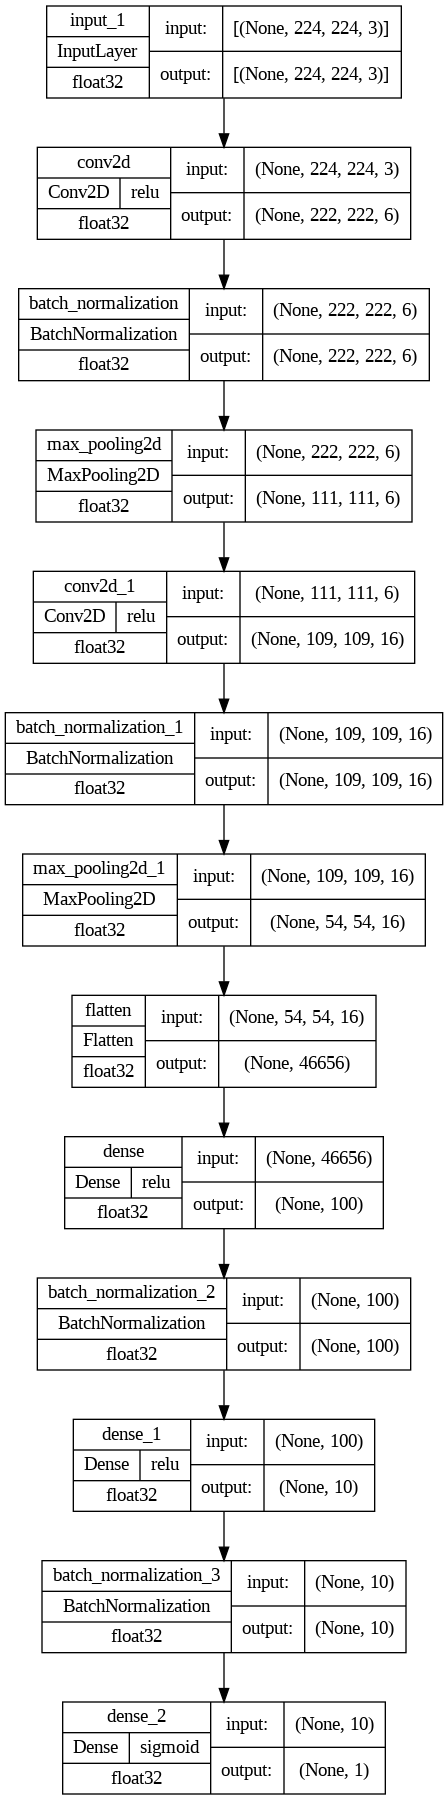

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_activations = True, show_dtype = True)

BINARY CROSS ENTROPY LOSS

In [ ]:
y_1 = tf.convert_to_tensor([0], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([1], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=15.333239>

In [ ]:
y_1 = tf.convert_to_tensor([0], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [ ]:
y_1 = tf.convert_to_tensor([0], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([1], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3132617>

In [ ]:
y_1 = tf.convert_to_tensor([0], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0.5], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.69314694>

In [ ]:
y_1 = tf.convert_to_tensor([0], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0.7], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2039725>

In [ ]:
y_1 = tf.convert_to_tensor([0], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0.85], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8971194>

In [ ]:
y_1 = tf.convert_to_tensor([0,1,0,1,1], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0.95,0.6,0.7,0.3,0], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.26789>

In [ ]:
y_1 = tf.convert_to_tensor([0,1,0,1,1], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0.95,0.6,0.7,0.3,0], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.81302655>

In [ ]:
y_1 = tf.convert_to_tensor([1], dtype = tf.float32)
y_1_pred = tf.convert_to_tensor([0], dtype = tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_1, y_1_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=15.424949>

**MODEL COMPILATION AND FITTING**

In [ ]:
METRICS = [BinaryAccuracy(name = 'accuracy'), TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

In [ ]:
csv_callback = CSVLogger('logs.csv', separator = ',', append = False)

In [ ]:
es_callback = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True )

In [ ]:
current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
metric_directory = "./logs/" + current_time + "/metrics"
train_writer = tf.summary.create_file_writer(metric_directory)

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()
  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
lrs_callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
mc_callback = ModelCheckpoint('/content/sample_data', monitor = 'val_loss', verbose = 1, save_best_only = True, save_weigths_only = True, mode = 'auto', save_frequency = 'epoch' )

In [ ]:
rlrop_callback = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2, verbose = 1 )

In [ ]:
pip install -U tensorboard_plugin_profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.7 MB/s eta 0:00:00


In [ ]:
current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
log_directory = "./logs" + current_time
tensorboard_callback = TensorBoard(log_dir = log_directory, profile_batch = '100,132')

In [ ]:
model.compile( optimizer = Adam(learning_rate = learning_rate), loss = BinaryCrossentropy(), metrics = METRICS )

In [ ]:
labels_ = ['Parasitized', 'Uninfected']

In [ ]:
#LOG IMAGES IN WANDB
#YOU COULD DOWNLOAD THESE IMAGES FROM WANDB WEBSITE
#HERE WE WILL LOG CONFUSION MATRIX AND ROC_CURVE FOR EACH EPOCH
class LogImagesCallbackWandb(Callback):
  def on_epoch_end(self, epoch, logs):
    #COPY AND PASTE CONFUSION MATRIX CODE
    labels = []
    inp = []
    for x, y in test_data.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array(i[0] for i in labels)
    inp = np.array(inp[:,0,...])
    predicted = model.predict(inp)
    predicted = predicted[:,0]

    #INPUT TO PROBS AND Y_PROBAS IN WANDB.LOG() SHOULD BE IN THE FORMAT [CLASS_1_PROBABILITY, CLASS_2_PROBABILITY]
    pred = []
    for i in range(len(predicted)):
      if predicted[i][0] < 0.5:
        pred.append([1,0])
      else:
        pred.append([0,1])
    pred = np.array(pred)

    #INFO IN WANDB.LOG() IS AUTOMATICALLY SAVED WHEN WANDBCALLBACK IS USED IN MODEL FITTING

    #TO LOG CONFUSION MATRIX
    wandb.log({"confusion_matrix" : wandb.plot.confusion_matrix(probs = pred, y_true = labels, class_names = ['Parasitized', 'Uninfected'])})

    #TO LOG ROC_CURVE
    wandb.log({"ROC_CURVE" : wandb.plot.roc_curve(y_true = labels, y_probas = pred, labels = ['Parasitized', 'Uninfected'])})

    #TO LOG LOSS (NOT IMAGE)
    wandb.log({'loss' : logs['loss']})

    threshold = 0.5
    cm = confusion_matrix(labels, prediction > threshold)
    plt.figure(figsize = (8,8))
    sns.heatmap(cm, annot = True)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis('off')

    buffer = io.BytesIO() #WE STORE THE IMAGE IN VARIABLE 'buffer'
    plt.savefig(buffer, format = 'png')

    image_array = tf.image.decode_png(buffer.get_value(), channels = 4) #GETTING IMAGE FROM SAVED PNG FILE 'buffer'

    #LOGGING IMAGES FROM ARRAYS
    images = wandb.Image(image_array, caption = "Confusion matrix for each epoch {}".format(epoch))
    wandb.log({'Confusion Matrix' : images})

In [ ]:
#LOG MATPLOTLIB IMAGES IN WANDB
plt.plot([1,2,3,4])
plt.ylabel("some interesting numbers")
wandb.log({'chart': plt})

In [ ]:
history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 20,
                    verbose = 1,
                    callbacks = [csv_callback, es_callback, lrs_callback, mc_callback, rlrop_callback, LogImagesCallbackTensorboard(), tensorboard_callback, LogImagesCallbackWandb(), WandbCallback(
                        validation_data = val_data,
                        labels = labels_,
                        data_type = image
                    )])

Epoch 1/20
689/689 [==============================] - 950s 1s/step - loss: 0.3002 - accuracy: 0.8802 - tp: 9820.0000 - fp: 1439.0000 - tn: 9585.0000 - fn: 1202.0000 - precision: 0.8722 - recall: 0.8909 - auc: 0.9433 - val_loss: 0.3291 - val_accuracy: 0.8791 - val_tp: 1379.0000 - val_fp: 317.0000 - val_tn: 1043.0000 - val_fn: 16.0000 - val_precision: 0.8131 - val_recall: 0.9885 - val_auc: 0.9667
Epoch 2/20
689/689 [==============================] - 856s 1s/step - loss: 0.2337 - accuracy: 0.9193 - tp: 10278.0000 - fp: 1034.0000 - tn: 9989.0000 - fn: 745.0000 - precision: 0.9086 - recall: 0.9324 - auc: 0.9616 - val_loss: 2.6546 - val_accuracy: 0.5506 - val_tp: 1380.0000 - val_fp: 1231.0000 - val_tn: 137.0000 - val_fn: 7.0000 - val_precision: 0.5285 - val_recall: 0.9950 - val_auc: 0.7065
Epoch 3/20
689/689 [==============================] - 842s 1s/step - loss: 0.2019 - accuracy: 0.9298 - tp: 10376.0000 - fp: 902.0000 - tn: 10122.0000 - fn: 646.0000 - precision: 0.9200 - recall: 0.9414 - a

In [ ]:
wandb.finish()

In [ ]:
%load_ext tensorboard

In [ ]:
#TENSORBOARD VISUALIZATIONS
tensorboard --logdir = log_directory

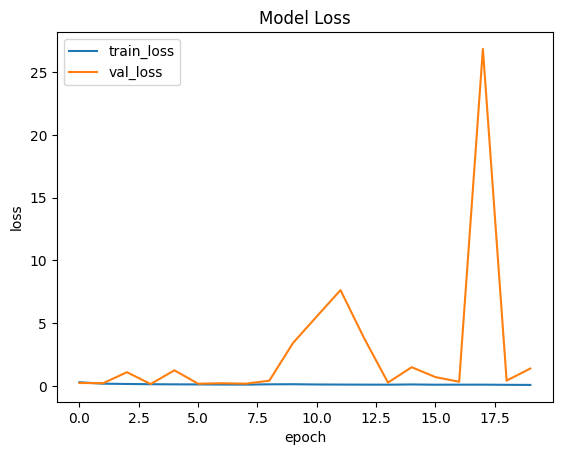

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

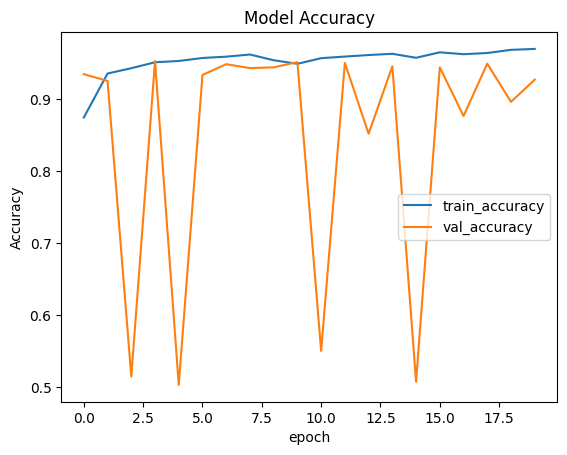

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### **MODEL EVALUATION AND TESTING**

In [ ]:
test_data

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
test_data = test_data.batch(1)

In [ ]:
model.evaluate(test_data)

2757/2757 [==============================] - 23s 5ms/step - loss: 0.8591 - accuracy: 0.9195 - tp: 1226.0000 - fp: 81.0000 - tn: 1309.0000 - fn: 141.0000 - precision: 0.9380 - recall: 0.8969 - auc: 0.9625


[0.859131395816803,
 0.9194777011871338,
 1226.0,
 81.0,
 1309.0,
 141.0,
 0.9380260109901428,
 0.8968544006347656,
 0.9624776244163513]

In [ ]:
model.predict(test_data.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.5875204

In [ ]:
def parasite_or_not(x):
  if x<0.5:
    return str("P")
  else:
    return str("U")

In [ ]:
parasite_or_not(model.predict(test_data.take(1))[0][0])

1/1 [==============================] - 10s 10s/step


'U'

**CONFUSION MATRIX**

In [ ]:
labels = []
inp = []
for x, y in test_data.as_numpy_iterator():
  labels.append(y)
  inp.append(x)
labels = np.array(i[0] for i in labels)
inp = np.array(inp[:,0,...])
predicted = model.predict(inp)
predicted = predicted[:,0]

threshold = 0.5
cm = confusion_matrix(labels, prediction > threshold)
print(cm)

NameError: name 'test_data' is not defined

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
#LOGGING IMAGES
#HERE WE WILL LOG CONFUSION MATERIX FOR EACH EPOCH
class LogImagesCallbackTensorboard(Callback):
  def on_epoch_end(self, epoch, logs):
    #COPY AND PASTE CONFUSION MATRIX CODE
    labels = []
    inp = []
    for x, y in test_data.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array(i[0] for i in labels)
    inp = np.array(inp[:,0,...])
    predicted = model.predict(inp)
    predicted = predicted[:,0]

    threshold = 0.5
    cm = confusion_matrix(labels, prediction > threshold)
    plt.figure(figsize = (8,8))
    sns.heatmap(cm, annot = True)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis('off')

    buffer = io.BytesIO() #WE STORE THE IMAGE IN VARIABLE 'buffer'
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.get_value(), channels = 4) #GETTING IMAGE FROM SAVED PNG FILE 'buffer'
    image = tf.expand_dims(image, axis = 0)

    current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    image_directory = "./logs/" + current_time + "/images"
    image_writer = tf.summary.create_file_writer(image_directory)

    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)


**ROC CURVE**

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
print(len(fp), len(tp), len(thresholds))

In [ ]:
#plotting line graph of fps with corresponding tps
plt.plot(fp, tp)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

plt.grid()

skip = 10
for i in range(0, len(threshold), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()
#find the optimal threshold from this to strike a balance bw fp rate and tp rate and is correct for given problem statement and do classification and confusion matrix (and its visualization) with this threshold


NameError: name 'plt' is not defined

VISUALIZE OUTPUT AS CORRECT LABEL VS PREDICTED LABEL

1/1 [==============================] - 0s 44ms/step


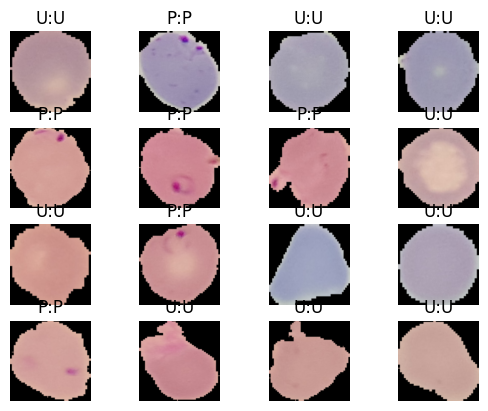

In [ ]:
for i, (image, label) in enumerate(train_data.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0]))) #true label : predicted label
  plt.axis("off")

### **FUNCTIONAL API**

In [ ]:
func_input = Input( shape = (im_size, im_size, 3))
x = Conv2D(filters = 6, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu')(func_input) #(5,5) and (1,1) can also be given as 5 and 1 respectively
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), strides = (2,2))(x) #(2,2) can also be given as 2

x = Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu')(x) #(5,5) and (1,1) can also be given as 5 and 1 respectively
x = BatchNormalization()(x)
feature_extraction = MaxPool2D(pool_size = (2,2), strides = (2,2))(x) #(2,2) can also be given as 2

x = Flatten()(feature_extraction)

x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

In [ ]:
model_func_api = Model(func_input, func_output, name = 'lenet_model')

In [ ]:
model_func_api.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      

In [ ]:
model_func_api.compile( optimizer = Adam(learning_rate = 0.01), loss = BinaryCrossentropy(), metrics = ['accuracy'] )

### **CALLABLE MODELS**

In [ ]:
func_input = Input( shape = (im_size, im_size, 3))
x = Conv2D(filters = 6, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu')(func_input) #(5,5) and (1,1) can also be given as 5 and 1 respectively
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), strides = (2,2))(x) #(2,2) can also be given as 2

x = Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu')(x) #(5,5) and (1,1) can also be given as 5 and 1 respectively
x = BatchNormalization()(x)
feature_extraction = MaxPool2D(pool_size = (2,2), strides = (2,2))(x) #(2,2) can also be given as 2


In [ ]:
feature_extraction_model = Model(func_input, feature_extraction, name = 'feature_extractor')

In [ ]:
feature_extraction_model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x79d80897ad40>>

In [ ]:
func_input = Input( shape = (im_size, im_size, 3))
x = feature_extraction_model(func_input) #we have called the model feature_extraction_model here

x = Flatten()(x)

x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

In [ ]:
model_ = Model(func_input, func_output, name = 'lenet_model_')

In [ ]:
model_.summary()


Model: "lenet_model_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)               

In [ ]:
model_feature_extraction = tf.keras.Sequential([
    InputLayer(input_shape = (im_size, im_size, 3)),

    Conv2D(filters = 6, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'), #(5,5) and (1,1) can also be given as 5 and 1 respectively
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2), strides = (2,2)), #(2,2) can also be given as 2

    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'), #(5,5) and (1,1) can also be given as 5 and 1 respectively
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2), strides = (2,2)) #(2,2) can also be given as 2

])
model_feature_extraction.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [ ]:
#we have used both Sequential API(model_feature_extraction) and Functional API here
func_input = Input( shape = (im_size, im_size, 3))
x = model_feature_extraction(func_input) #we have called the model model_feature_extraction here

x = Flatten()(x)

x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

In [ ]:
model_s_f = Model(func_input, func_output, name = '_lenet_model_')
model_s_f.summary()

Model: "_lenet_model_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_14 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                     

### **MODEL SUBCLASSING**

In [ ]:
class feature_extractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(feature_extractor, self).__init__() #important to do in subclassing a layer
        self.conv1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation) #(5,5) and (1,1) can also be given as 5 and 1 respectively
        self.batch1 = BatchNormalization()
        self.maxpool1 = MaxPool2D(pool_size = pool_size, strides = 2*strides) #(2,2) can also be given as 2

        self.conv2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)#(5,5) and (1,1) can also be given as 5 and 1 respectively
        self.batch2 = BatchNormalization()
        self.maxpool2 = MaxPool2D(pool_size = pool_size, strides = 2*strides) #(2,2) can also be given as 2

  def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpool2(x)

        return x



In [ ]:
subclassing_layer = feature_extractor(8, 3, 1, 'valid', 'relu', 2)

In [ ]:
#we have used both Sequential API(model_feature_extraction) and Functional API here
func_input = Input( shape = (im_size, im_size, 3))
x = subclassing_layer(func_input) #we have called the model model_feature_extraction here

x = Flatten()(x)

x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

In [ ]:
model_s_ = Model(func_input, func_output, name = '_lenet_model_')
model_s_.summary()

Model: "_lenet_model_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (feature  (None, 54, 54, 16)        1488      
 _extractor)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 46656)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_18 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 10)              

In [ ]:
class LenetModel(Model):
  def __init__(self):
        super(LenetModel, self).__init__() #important to do in subclassing a layer

        self.feature_extractor = feature_extractor(8, 3, 1, 'valid', 'relu', 2)
        self.flatten = Flatten()
        self.dense_1 = Dense(100, activation = 'relu')
        self.batch_1 = BatchNormalization()
        self.dense_2 = Dense(10, activation = 'relu')
        self.batch_2 = BatchNormalization()
        self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        return x



In [ ]:
lenet_subclassed = LenetModel()
lenet_subclassed.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
lenet_subclassed = LenetModel()
lenet_subclassed(tf.zeros([1,224,224,3]))
lenet_subclassed.summary()

Model: "lenet_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_2 (featu  multiple                  1488      
 re_extractor)                                                   
                                                                 
 flatten_6 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_26 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_27 (Ba  multiple                

### **CUSTOM LAYERS**

FOR DENSE LAYER

In [ ]:
class Neural_Dense(Layer):
  def __init__(self, output_units, activation):
    super(Neural_Dense, self).__init__()
    self.output_units = output_units
    self.activation = activation
  def build(self, input_features_shape):
    self.w = self.add_weights(shape = (input_features_weights[-1], output_units), initializer = 'random_normal', trainable = True)
    self.b = self.add_weights(shape = (input_features_weights[-1],), initializer = 'random_normal', trainable = True)
  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if self.activation == 'relu':
      return tf.nn.relu(pre_output)
    elif self.activation == 'sigmoid':
      return tf.nn.sigmoid(pre_output)
    else:
      return pre_output


NameError: name 'Layer' is not defined

### **CUSTOM CALLBACK**

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n epoch no {} has loss of {}".format(epoch+1, logs['loss']))
  def on_batch_end(self, batch, logs):
    print("\n batch no {} has loss of {}".format(batch+1, logs))

### **DATA AUGMENTATION**

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image = next(iter(train_dataset))
augmented_image = tf.image.flip_left_right(original_image)
visualize(original_image, augmented_image)

In [ ]:
augmented_image_rud = tf.image.random_flip_up_down(original_image, seed = 42)
visualize(original, augmented_image_rud)

In [ ]:
augmented_image_r90 = tf.image.rot90(original_image, k = 1)
visualize(original, augmented_image_r90)

In [ ]:
augmented_image_r180 = tf.image.rot90(original_image, k = 2)
visualize(original, augmented_image_r180)

In [ ]:
augmented_image_r270= tf.image.rot90(original_image, k = 3)
visualize(original, augmented_image_r270)

In [ ]:
augmented_image_r360 = tf.image.rot90(original_image, k = 4)
visualize(original, augmented_image_r360)

In [ ]:
augmented_image_ab = tf.image.adjust_brightness(original_image, delta = 0.2) #delta should be in range [-1, 1]
visualize(original, augmented_image_ab)

In [ ]:
augmented_image_rs = tf.image.random_saturation(original_image, lower = 2, upper = 10)
visualize(original, augmented_image_rs)

In [ ]:
augmented_image_cc = tf.image.central_crop(original_image, central_fraction = 0.7)
visualize(original, augmented_image_cc)

### **CUSTOM LOSS**

i) CREATING A METHOD/ FUNCTION THAT CAN BE CALLED WITHOUT PARAMETERS

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

In [ ]:
model.compile( optimizer = Adam(learning_rate = 0.01), loss = custom_bce(), metrics = METRICS )

ii) CREATING A METHOD/ FUNCTION THAT is WITH PARAMETERS

In [ ]:
factor = 1
def custom_bce(y_true, y_pred, factor):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * factor
  return loss

In [ ]:
model.compile( optimizer = Adam(learning_rate = 0.01), loss = custom_bce(factor), metrics = METRICS )

iii) CREATING A CLASS THAT INHERITS FROM tf.keras.losses.Loss

In [ ]:
class custom_bce(tf.keras.losses.Loss):
  def __init__(self, factor):
    super(custom_bce, self).__init__()
    self.factor = factor
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * self.factor

In [ ]:
model.compile( optimizer = Adam(learning_rate = 0.01), loss = custom_bce(factor), metrics = METRICS )

SAME 3 WAYS OF CUSTOM METRICS APPLY

EXAMPLE : CREATING CLASS THAT INHERITS FROM tf.keras.metrics.Metric

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'custom_accuracy', factor):
    super(CustomAccuracy, self).__init__()
    self.factor = factor
    self.accuracy = self.add_weights(name = name, initializer = 'zeros')
  def update_state(self,y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred) * self.factor
    self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))
  def result(self):
    return self.accuracy
  def reset_states(self):
    self.accuracy.assign(0.)

In [ ]:
factor = 0.8

In [ ]:
model.compile( optimizer = Adam(learning_rate = 0.01), loss = BinaryCrossentropy(), metrics = CustomAccuracy(factor) )

PRINTING IN GRAPH MODE

In [ ]:
#eager mode
def a():
  print("aa")

a()
a()
a()

aa
aa
aa


In [ ]:
import tensorflow as tf
@tf.function
def a():
  print("aa")

a()
a()
a()

aa


In [ ]:
@tf.function
def a():
  tf.print("aa")

a()
a()
a()

aa
aa
aa


### **CUSTOM TRAINING LOOPS**

In [ ]:
'''optimizer = Adam(learning_rate = 0.01)
epochs = 3
metric = BinaryAccuracy()
metric_val = BinaryAccuracy()'''

In [ ]:
import wandb

#wandb.tensorboard.patch(root_logdir = "./logs/")
#wandb.init(project = 'malaria_detection', entity = 'jagaadhep')

#OR

wandb.init(project = 'malaria_detection___', entity = 'jagaadhep', sync_tensorboard = True)

In [ ]:
#LOGGING FOR USAGE IN TENSORBOARD
current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
custom_train_directory = "./logs/" + current_time + "/custom/train"
custom_validation_directory = "./logs/" + current_time + "/custom/validation"
custom_train_writer = tf.summary.create_file_writer(custom_train_directory)
custom_validation_writer = tf.summary.create_file_writer(custom_validation_directory)

In [ ]:
#TO DO TRAINING
def training_block(x_batch, y_batch):
  with tf.GradientTape as recorder: #records operations during automatic differentiation like gradients
    y_pred = model(x_batch, training = True):
    bce = BinaryCrossentropy()
    loss = bce(y_batch, y_pred)
  #wandb.log({'loss': loss.numpy()})
  partial_derivatives = recorder.gradient(loss, model.trainable_weights = True) #compute gradients
  optimizer.apply_gradients(zip(partial_derivatives, model.trainable_weights)) #update weights
  metric.update_state(y_batch, y_pred)
  return loss

In [ ]:
#TO DO VALIDATION
def val_block(x_batch_val, y_batch_val):
    y_pred_val = model(x_batch_val, training = False)
    bce = BinaryCrossentropy()
    loss_val = bce(y_batch_val, y_pred_val)

    metric_val.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
@tf.function #RUNNING EVERYTHING IN GRAPH MODE
def neuralearn(model, loss_function, metric, metric_val, optimizer, train_data, val_data, epochs):
  for epoch in epochs:
    print('Training starts for epoch number {}'format(epoch))
    for step, (x_batch, y_batch) in enumerate(train_data):
      loss = training_block(x_batch, y_batch)
    print("Training loss : ",loss)
    print("Training Binary Accuracy : ",metric.result())
    #logging accuracy and loss
    with custom_train_writer.as_default():
      tf.summary.scalar('Train loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Train Accuracy', data = metric.result(), step = epoch)
    metric.reset_states() #reset metric to 0 after the epoch is over

    #VALIDATION
    for (x_batch_val, y_batch_val) in val_data:
      loss_val = val_block(x_batch_val, y_batch_val)
    print("Validation loss : ", loss_val)
    print("Validation Binary Accuracy : ",metric_val.result())
    #logging accuracy and loss
    with custom_validation_writer.as_default():
      tf.summary.scalar('Validation loss', data = loss_val, step = epoch)
    with custom_validation_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = metric_val.result(), step = epoch)
    metric_val.reset_states() #reset metric to 0 after the epoch is over

In [ ]:
neuralearn(model_s_, BinaryCrossentropy(), BinaryAccuracy(), BinaryAccuracy(), Adam(learning_rate = 0.01), train_data, val_data, 3)

### **HYPERPARAMETER TUNING WITH WANDB**

In [ ]:
#MAKE USE OF THE CONFIGURATIONS WE HAVE HAVE ALREADY DEFINED AT THE BEGINNING OF THE NOTEBOOK
sweep_config = {
    "name" : "malaria_prediction_sweep",
    "method" : "random",
    "metric" : {
        "name" : "accuracy",
        "goal" : "maximize"
    },
    "parameters" : {
        "N_DENSE_1" : {
            "values" : [16, 32, 64, 128]
        },
        "N_DENSE_2" : {
            "values" : [16, 32, 64, 128]
        },
        "DROPOUT_RATE" : {
            "min" : 0.1,
            "max" : 0.4
        },
        "REGULARIZATION_RATE" : {
            "distribution" : "uniform",
            "min" : 0.001,
            "max" : 0.1
        }
        "LEARNING_RATE" : {
            "distribution" : "uniform",
            "min" : 1e-4,
            "max" : 1e-2
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
#MAKE USE OF THE CONFIGURATIONS WE HAVE HAVE ALREADY DEFINED AT THE BEGINNING OF THE NOTEBOOK
def model_tune(config):
  hyp_model = tf.keras.Sequential([
      InputLayer(input_shape = (config.IM_SIZE, config.IM_SIZE, 3)),

      '''used for data agumentation with tf.keras.layers:
      resize_rescale_layer,
      augment_'''

      Conv2D(filters = config.N_FILTERS, kernel_size = config.KERNEL_SIZE, strides = config.N_STRIDES, padding = 'valid', activation = 'relu', kernel_regularizer  = L2(config.REGULARIZATION_RATE)), #(5,5) and (1,1) can also be given as 5 and 1 respectively
      BatchNormalization(),
      MaxPool2D(pool_size = config.POOL_SIZE, strides = config.N_STRIDES), #(2,2) can also be given as 2
      Dropout(rate = config.DROPOUT_RATE),

      Conv2D(filters = config.N_FILTERS, kernel_size = config.KERNEL_SIZE, strides = config.N_STRIDES, padding = 'valid', activation = 'relu', kernel_regularizer  = L2(config.REGULARIZATION_RATE)), #(5,5) and (1,1) can also be given as 5 and 1 respectively
      BatchNormalization(),
      MaxPool2D(pool_size = config.POOL_SIZE, strides = config.N_STRIDES), #(2,2) can also be given as 2

      Flatten(),

      Dense(config.N_DENSE_1, activation = 'relu', kernel_regularizer  = L2(config.REGULARIZATION_RATE)),
      BatchNormalization(),
      Dropout(rate = config.DROPOUT_RATE),
      Dense(config.N_DENSE_2, activation = 'relu', kernel_regularizer  = L2(config.REGULARIZATION_RATE )),
      BatchNormalization(),
      Dense(1, activation = 'sigmoid', kernel_regularizer  = L2(config.REGULARIZATION_RATE ))
  ])

  return hyp_model

In [ ]:
def train():
  with wandb.init(project = "malaria_detection_", entity = "jagaadhep", config = configuration) as run:
    config = wandb.config
    model = model_tune(config)
    model.compile( optimizer = Adam(learning_rate = config.LEARNING_RATE), loss = BinaryCrossentropy(), metrics = ['accuracy'] )
    model.fit(val_data, epochs = config.N_EPOCHS, callbacks = [WandbCallback()] )

count = 5 #NUMBER OF RUNS TO EXECUTE
wandb.agent(sweep_id, funcion = train, count = count)

### **HYPERPARAMETER TUNING WITH TENSORBOARD**

In [ ]:
def model_tune(hparams):
  hyp_model = tf.keras.Sequential([
      InputLayer(input_shape = (none, none, 3)),

      '''used for data agumentation with tf.keras.layers:
      resize_rescale_layer,
      augment_'''

      Conv2D(filters = 6, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu', kernel_regularizer  = L2(hparams[HP_REGULARIZATION_RATE] )), #(5,5) and (1,1) can also be given as 5 and 1 respectively
      BatchNormalization(),
      MaxPool2D(pool_size = (2,2), strides = (2,2)), #(2,2) can also be given as 2
      Dropout(rate = hparams[HP_DROPOUT]),

      Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu', kernel_regularizer  = L2(hparams[HP_REGULARIZATION_RATE] )), #(5,5) and (1,1) can also be given as 5 and 1 respectively
      BatchNormalization(),
      MaxPool2D(pool_size = (2,2), strides = (2,2)), #(2,2) can also be given as 2

      Flatten(),

      Dense(hparams[HP_NUM_UNITS_1], activation = 'relu', kernel_regularizer  = L2(hparams[HP_REGULARIZATION_RATE] )),
      BatchNormalization(),
      Dropout(rate = hparams[HP_DROPOUT]),
      Dense(hparams[HP_NUM_UNITS_2], activation = 'relu', kernel_regularizer  = L2(hparams[HP_REGULARIZATION_RATE] )),
      BatchNormalization(),
      Dense(1, activation = 'sigmoid', kernel_regularizer  = L2(hparams[HP_REGULARIZATION_RATE] ))
  ])
  METRICS = [BinaryAccuracy(name = 'accuracy')]
  model_hyp.compile( optimizer = Adam(learning_rate = hparams[HP_LEARNING_RATE]), loss = BinaryCrossentropy(), metrics = METRICS )
  history = model_hyp.fit(val_data, epochs = 2)

  loss, accuracy = model_hyp.evaluate(val_data)
  print(loss, accuracy)
  return accuracy

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4,1e-3]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.vales:

          hparams = {
              HP_NUM_UNITS_1 : num_units_1,
              HP_NUM_UNITS_2 : num_units_2,
              HP_DROPOUT : dropout_rate,
              HP_REGULARIZATION_RATE : regularization_rate,
              HP_LEARNING_RATE : learning_rate
          }

          file_writer = tf.summary.create_file_writer('logs/hparams - '  + str(run_number))

          with file_writer.as_default():
            hp.hparams(hparams)
            accuracy = model_tune(hparams)
            tf.summary.scalar('accuracy', accuracy, step = 0) #step = 0 or 1
          print("For the run {} : \n hparams num_unit_1 : {}, num_unit_2 : {}, dropout_rate : {}, regularization_rate : {}, learning_rate : {} ".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2], hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE], hparams[HP_LEARNING_RATE]))
          run_number += 1

In [ ]:
tensorboard --logdir = './logs'
#CHOOSE THE HYPERPARAMETERS WITH THE HIGHEST ACCURACY IN PARALLEL COORDINATES VIEW IN HPARAMS IN TENSORBOARD INTERFACE
#THEN MODEL THE MAIN MODEL 'MODEL' ACCORDING TO THE BEST HYPERPARAMETERS